In [2]:
import numpy as np
from solvers.centralized_mpc import *
from solvers.distributed_mpc import *
from solvers.util import *
from dpilqr import plot_solve
import matplotlib.pyplot as plt
import os
import solvers.util as util

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from dpilqr import random_setup,pos_mask


In [5]:
# data_15_distributed= np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/15_drones_distributed_sim_data.npy')
# data_15_centralized = np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/15_drones_centralized_sim_data.npy')

# data_10_distributed= np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/10_drones_distributed_sim_data.npy')
# data_10_centralized = np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/10_drones_centralized_sim_data.npy')

# data_5_distributed= np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/5_drones_distributed_sim_data.npy')
# data_5_centralized = np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/5_drones_centralized_sim_data.npy')


## We analyze the optimality gap between centralized vs decentralized through a concrete example:

In [6]:
theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 20
tau_min = 0

x_min = -10
x_max = 10

y_min = -10
y_max = 10

z_min = 0
# z_max = 3.0
z_max = 4.0

max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min],[v_min]])


centralized = True
soft_constraint = False
equal_dist = True

In [18]:
unit_dist = 1
dt = 0.1
radius = 0.35
N = 15
n_states = 6
n_inputs = 3
n_agents = 5
max_input = np.tile(max_input_base,(n_agents,1))
min_input = np.tile(min_input_base,(n_agents,1))
max_state = np.tile(max_state_base,(n_agents,1))
min_state = np.tile(min_state_base,(n_agents,1))

In [ ]:
# x0, xf = util.paper_setup_5_quads()

In [ ]:
x0,xf = util.setup_5_quads()
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g])
Q = np.eye(n_agents*n_states)*100
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000
n_dims = [3]*5
n_humans = 0

In [20]:
print(x0.T)

[[ 0.5  1.5  1.   0.   0.   0.   2.5  1.5  1.   0.   0.   0.   1.5  1.3
   1.   0.   0.   0.  -0.5  0.5  1.   0.   0.   0.   1.1  1.1  1.   0.
   0.   0. ]]


In [21]:
print(xf.T)

[[ 2.5  1.5  1.   0.   0.   0.   0.5  1.5  1.   0.   0.   0.   1.5  2.2
   1.   0.   0.   0.  -0.5  1.5  1.   0.   0.   0.  -1.1  1.1  1.   0.
   0.   0. ]]


In [22]:
X_full,U_full, t, failed_count, converged = solve_rhc(
                                            dt,x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius,
                                            max_input,min_input,max_state,min_state,n_humans)

Total number of variables............................:      705
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:     1570
        inequality constraints with only lower bounds:      865
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      705


Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:   3.4423753147505050e+02    1.7211876573752525e+04
Dual infeasibility......:   4.4586556668946287e-11    2.2293278334473143e-09
Constraint violation....:   9.9742436532324064e-13    9.9742436532324064e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

In [23]:
X_full.shape

(34, 30)

In [24]:
X_full.T.shape

(30, 34)

In [25]:
xf.shape

(30, 1)

In [26]:
x_dims = [n_agents]*n_states

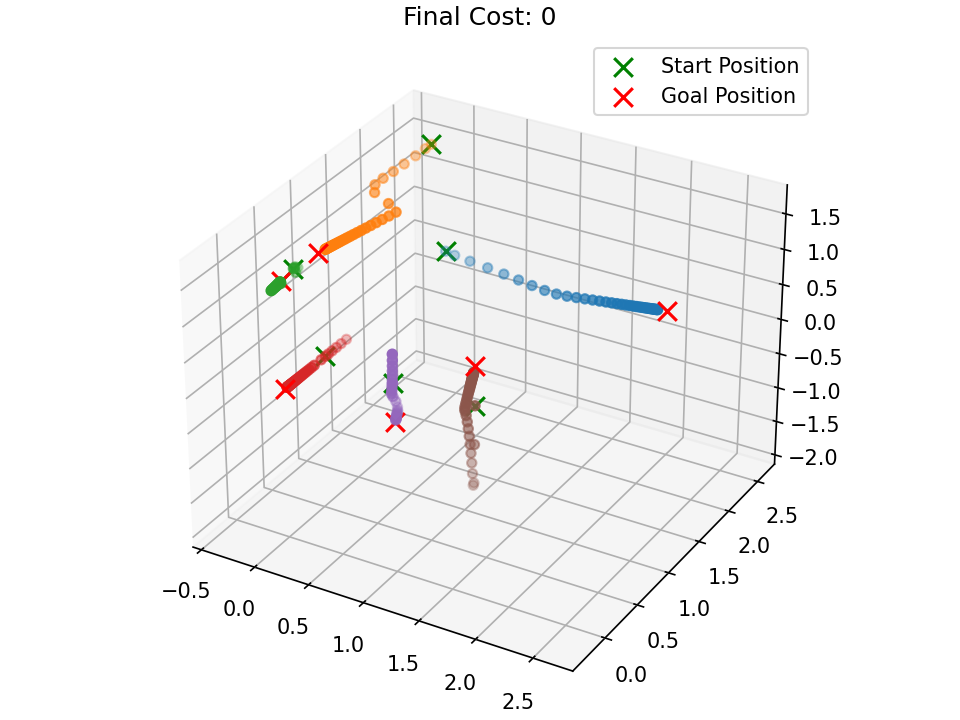

In [27]:
%matplotlib ipympl
plt.figure(dpi=150)
plot_solve(X_full,0,xf,x_dims,n_d=3,color_agents=True)
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# plt.savefig('results/Distributed MPC(IPOPT)10_drones.png');

In [14]:
print(f'Total cost for the entire resultant trajectory from centralized solver is {objective(X_full.T,U_full.T,u_ref,xf,Q,R,Qf)}') 


Total cost for the entire resultant trajectory from centralized solver is [541.286]


In [16]:
n_dims = [3]*5
ids =  [100 + i for i in range(n_agents)]
X_dec, U_dec, t, failed_count, converged = solve_rhc_distributed(
                                    dt,x0, xf, u_ref, N, Q,R, Qf, n_agents, n_states, n_inputs, radius, ids,\
                                    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
                                    theta_min,tau_max,tau_min,phi_max,phi_min,n_humans,n_dims,j_trial=None,equal_dist = False
                                        )

determining interaction graph with the following pair-wise distance : [[2.066 0.991 1.413 0.761 1.106 3.224 1.479 2.138 0.403 1.748]]
prob is 100, ids is [100]
Solving the 0th sub-problem at iteration 0, t = 0 

current sub-problem has state dimension : [6] 

number of drones in the current subproblem is 1

number of humans in the current subproblem is None

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 102.40us (  6.02us)        17
       nlp_g  |        0 (       0) 427.20us ( 25.13us)        17
  nlp_grad_f  |        0 (       0) 401.70us ( 22.32us)        18
  nlp_hess_l  |        0 (       0) 270.00us ( 16.88us)        16
   nlp_jac_g  |        0 (       0) 334.30us ( 18.57us)        18
       total  |  62.50ms ( 62.50ms)  51.36ms ( 51.36ms)         1
solve time for the current sub-problem is 0.06565000000409782 

prob is 101, ids is [101]
Solving the 1th sub-problem at iteration 0, t = 0 

current sub-problem has state dimen

In [ ]:
X_dec.shape

In [17]:
print(f'Total cost for the entire resultant trajectory from decentralized solver is {objective(X_dec.T,U_dec.T,u_ref,xf,Q,R,Qf)}') 

Total cost for the entire resultant trajectory from decentralized solver is [573.627]


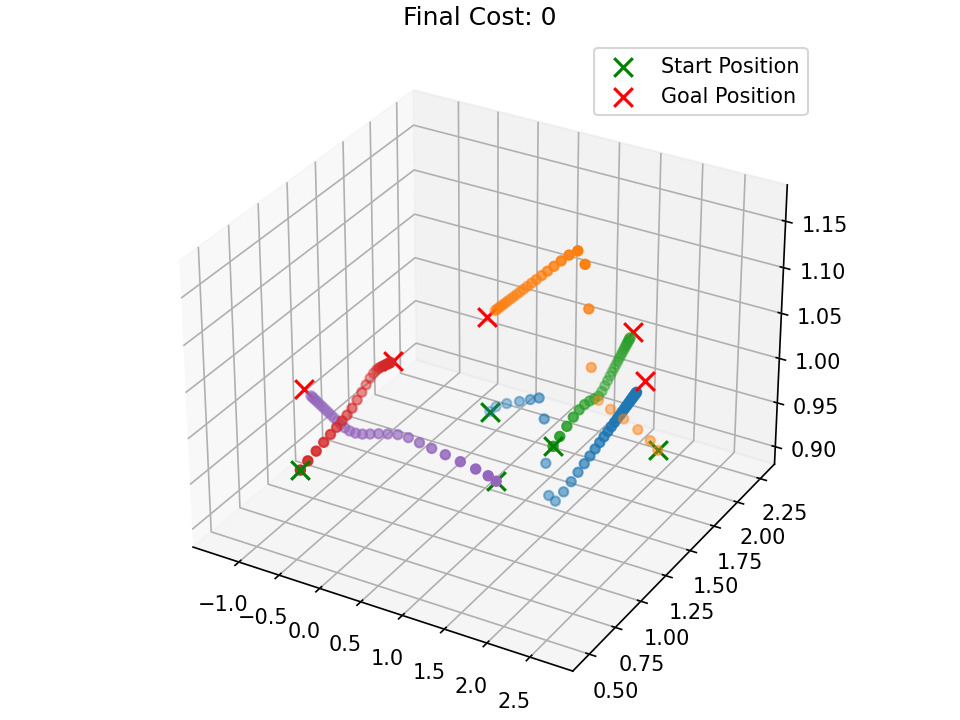

In [18]:
%matplotlib ipympl
plt.figure(dpi=150)
plot_solve(X_dec,0,xf,x_dims,n_d=3,color_agents=True)
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])

In [4]:
n_agents = 4
n_states = 6
x_dims = [n_states]*n_agents
unit_dist=1

In [5]:
data = np.load('/mnt/c/Users/Randy666/Documents/projects/ICON_lab/distributed_opt/distributed_mpc/simulation_data(drones)/4_drones_distributed_sim_data.npy')

In [6]:
x0 = np.array([[
            2 ,0, 1, 0, 0, 0,
            2, 1, 1, 0, 0, 0,
            1.5, 1.5, 1.5, 0, 0, 0,
            2.5, 2.5, 1.5, 0, 0, 0]], 
            dtype=float).T
xf = np.array([[
            2+unit_dist*2 ,0+unit_dist*2, 1.5, 0, 0, 0,
            2+unit_dist*2, 1+unit_dist*2, 1.5, 0, 0, 0,
            3.5, 1.5, 1.5, 0, 0, 0, 
            2.5, -1.0, 1.5, 0, 0, 0]], 
            dtype=float).T

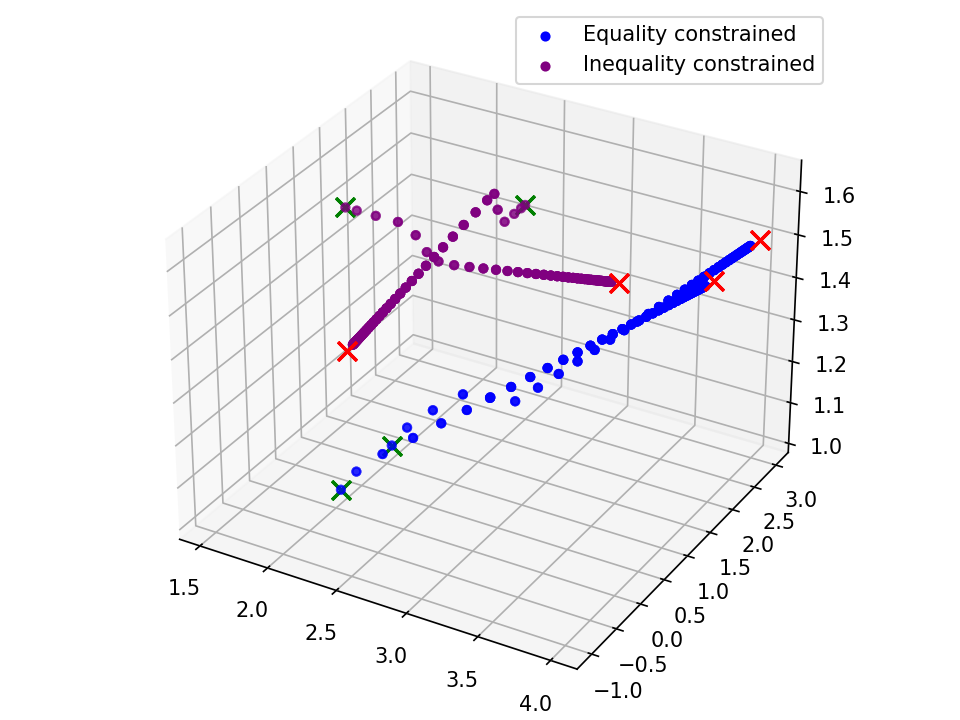

In [8]:
%matplotlib ipympl
fig = plt.figure(dpi=150)
ax = plt.gcf().add_subplot(projection="3d")
N = data.shape[0]
n = np.arange(N)

X_split = split_agents(data, x_dims)
x_goal_split = split_agents(xf.reshape(1, -1), x_dims)

for i in range(4):
    for i, (Xi, xg) in enumerate(zip(X_split[0:2], x_goal_split[0:2])):
            c = 'b'
            
            l1 = ax.scatter(Xi[:, 0], Xi[:, 1], Xi[:, 2], s=15, c=c)
            ax.scatter(
                Xi[0, 0], Xi[0, 1], Xi[0, 2], s=80, c="g", marker="x", label="$x_0$"
            )
            ax.scatter(
                xg[0, 0], xg[0, 1], xg[0, 2], s=80, c="r", marker="x", label="$x_f$"
            )
    for i, (Xi, xg) in enumerate(zip(X_split[2:], x_goal_split[2:])):
            c = 'purple'
            
            l2 = ax.scatter(Xi[:, 0], Xi[:, 1], Xi[:, 2], s=15, c=c)
            ax.scatter(
                Xi[0, 0], Xi[0, 1], Xi[0, 2], s=80, c="g", marker="x", label="$x_0$"
            )
            ax.scatter(
                xg[0, 0], xg[0, 1], xg[0, 2], s=80, c="r", marker="x", label="$x_f$"
            )
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.legend((l1,l2),["Equality constrained","Inequality constrained"])

In [9]:
data.shape

(39, 24)

In [20]:
compute_pairwise_distance(data,x_dims).shape

(39, 6)

In [32]:
plt.close('all')

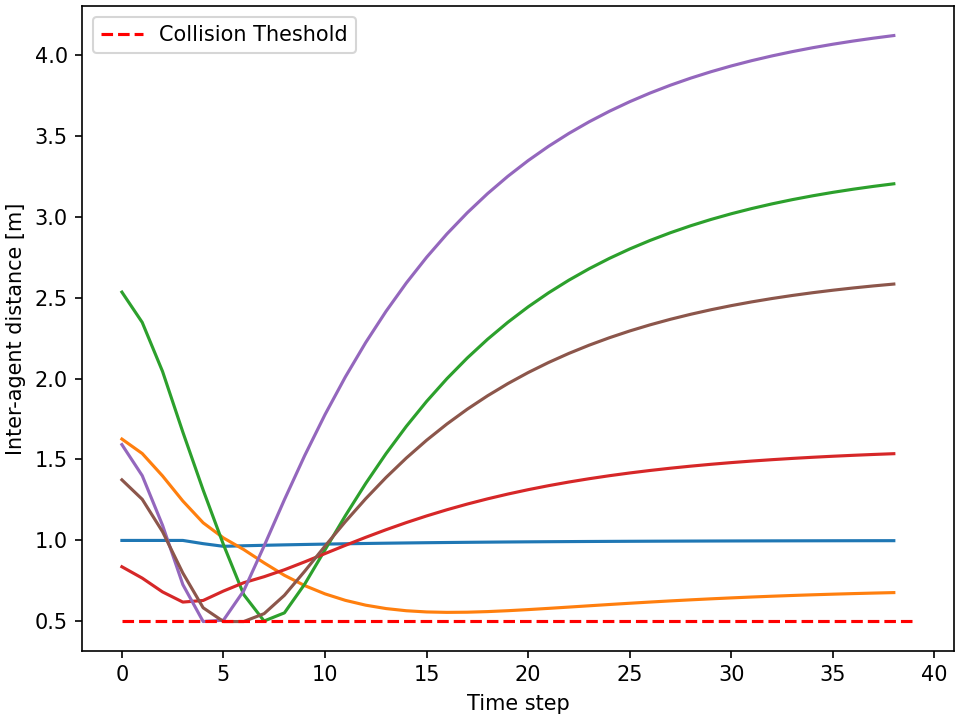

In [48]:
plt.figure(dpi=150)
plt.plot(compute_pairwise_distance(data,x_dims));
plt.hlines(0.5, 0, data.shape[0], 'r', ls='--', label="Collision Theshold")
# plt.title("Inter-Agent Distances (w/ hard constraint)")
plt.xlabel("Time step")
plt.ylabel("Inter-agent distance [m]")
# plt.ylim(0.15,2.25)
np.set_printoptions(precision=0)
plt.legend(loc='upper left')
# plt.grid()
plt.savefig('4_drone_equal_distance_paper.png')
plt.draw()

In [18]:
dt = 0.1
radius = 0.35
N = 15
n_states = 6
n_inputs = 3
n_agents = 6
max_input = np.tile(max_input_base,(n_agents,1))
min_input = np.tile(min_input_base,(n_agents,1))
max_state = np.tile(max_state_base,(n_agents,1))
min_state = np.tile(min_state_base,(n_agents,1))

In [19]:
x0 = np.array([[0.5, 1.5, 1, 0.1, 0.0, 0,
                    2.5, 1.5, 1, -0.1, 0.0, 0,
                    1.5, 1.3, 1, 0, 0.1, 0,
                    0.5, 1.0, 1, 0.1, 0, 0,
                    1.2, -0.5, 1, 0, 0, 0,
                    -1.0, 0.8, 1, 0, 0, 0]]).T
xf = np.array([[2.5, 1.5, 1, 0, 0, 0,
                0.5, 1.5, 1, 0, 0, 0,
                1.5, 2.2, 1, 0, 0, 0,
                -0.5, -0.6, 1, 0, 0, 0,
                -0.7, 1.0, 1, 0, 0, 0,
                0.5, -1.5, 1, 0., 0, 0]]).T

x0[pos_mask([6]*6, 3)] += 0.1*np.random.randn(18, 1)
xf[pos_mask([6]*6, 3)] += 0.1*np.random.randn(18, 1)

In [20]:
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,g,0,0,g,0,0,g])
Q = np.eye(n_agents*n_states)*100
R = np.eye(n_agents*n_inputs)*0.01
Qf = np.eye(n_agents*n_states)*1000
n_dims = [3]*n_agents
n_humans = 0


In [21]:
n_agents

6

In [22]:
x0.T

array([[ 0.54 ,  1.436,  0.851,  0.1  ,  0.   ,  0.   ,  2.521,  1.378,
         1.004, -0.1  ,  0.   ,  0.   ,  1.438,  1.421,  1.007,  0.   ,
         0.1  ,  0.   ,  0.452,  1.072,  1.077,  0.1  ,  0.   ,  0.   ,
         1.226, -0.512,  0.979,  0.   ,  0.   ,  0.   , -0.829,  0.826,
         1.023,  0.   ,  0.   ,  0.   ]])

In [23]:
xf.T

array([[ 2.347,  1.519,  1.021,  0.   ,  0.   ,  0.   ,  0.511,  1.539,
         1.058,  0.   ,  0.   ,  0.   ,  1.548,  2.167,  0.735,  0.   ,
         0.   ,  0.   , -0.444, -0.444,  0.88 ,  0.   ,  0.   ,  0.   ,
        -0.661,  1.011,  0.93 ,  0.   ,  0.   ,  0.   ,  0.374, -1.387,
         0.909,  0.   ,  0.   ,  0.   ]])

In [24]:
x_dims = [6]*n_agents
x_dims

[6, 6, 6, 6, 6, 6]

In [25]:
dec.compute_pairwise_distance(x0,x_dims,3)

array([[1.988, 0.911, 0.437, 2.069, 1.508, 1.084, 2.093, 2.291, 3.395,
        1.048, 1.945, 2.343, 1.766, 1.305, 2.452]])

In [26]:
X_full,U_full, t, failed_count, converged = solve_rhc(
                                dt,x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,n_inputs,radius,
                                max_input,min_input,max_state,min_state,n_humans)

Total number of variables............................:      846
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      576
Total number of inequality constraints...............:     1932
        inequality constraints with only lower bounds:     1086
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      846


Number of Iterations....: 30

                                   (scaled)                 (unscaled)
Objective...............:   5.7426422178948326e+02    2.6953727427662896e+04
Dual infeasibility......:   1.3331558079698880e-12    6.2573144735802037e-11
Constraint violation....:   7.2164496600635175e-16    7.2164496600635175e-16
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

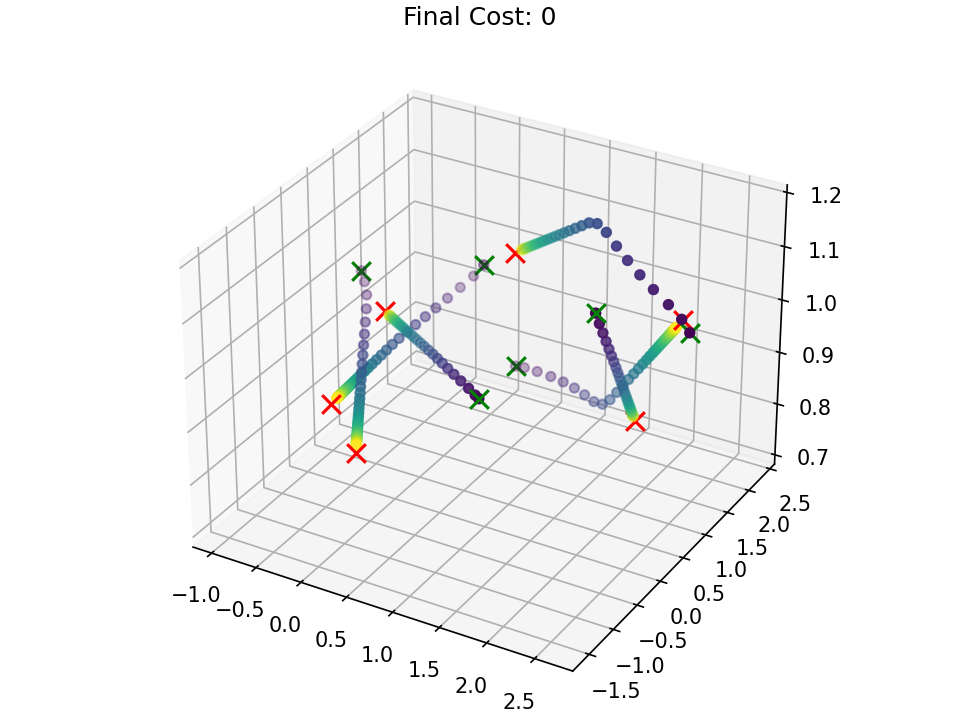

In [27]:
%matplotlib ipympl
plt.figure(dpi=150)
dec.plot_solve(X_full,0,xf,x_dims,n_d=3)